# Long Shorterm Memory Neural Network (LSTM NN)

### Import libraries

In [1]:
import numpy as np
import pandas as pd
import math
import json

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Import graphical tools
import matplotlib.pyplot as plt

import plotly as py
import plotly.graph_objs as go
import ipywidgets as widgets
from scipy import special

py.offline.init_notebook_mode(connected = True)

### Data preparation

In [2]:
# Import datasets and create dataframes 

path_machine = path_machine # path of realKnownCause/machine_temperature_system_failure.csv 

path_cloud_train = path_cloud_train # path of realAWSCloudwatch/rds_cpu_utilization_cc0c53.csv

path_cloud_test = path_cloud_test # path of realAWSCloudwatch/rds_cpu_utilization_e47b3b.csv

data_used = 'cloud'

def dataframe_creator(data_name):
    if data_name == 'cloud':
        df_train = pd.read_csv(path_cloud_train, parse_dates = True, index_col = 'timestamp')
        df_test = pd.read_csv(path_cloud_test, parse_dates = True, index_col = 'timestamp')
        
        filename = ['realAWSCloudwatch/rds_cpu_utilization_cc0c53.csv', 'realAWSCloudwatch/rds_cpu_utilization_e47b3b.csv']
        
    elif data_name == 'machine': 
        df = pd.read_csv(path_machine, parse_dates = True, index_col = 'timestamp')
        
        df_train = df[:round(len(df)*0.8)] # 75% training data
        df_test = df[round(len(df)*0.8):] # 25% test data
        
        filename = 'realKnownCause/machine_temperature_system_failure.csv'
        
    return filename, df_train, df_test

In [3]:
filename, df_train, df_test = dataframe_creator(data_used)

# Quick look at the data
print(filename)
print(df_train.head())

print(df_test.head())

['realAWSCloudwatch/rds_cpu_utilization_cc0c53.csv', 'realAWSCloudwatch/rds_cpu_utilization_e47b3b.csv']
                     value
timestamp                 
2014-02-14 14:30:00  6.456
2014-02-14 14:35:00  5.816
2014-02-14 14:40:00  6.268
2014-02-14 14:45:00  5.816
2014-02-14 14:50:00  5.862
                      value
timestamp                  
2014-04-10 00:02:00  14.012
2014-04-10 00:07:00  13.334
2014-04-10 00:12:00  15.000
2014-04-10 00:17:00  13.998
2014-04-10 00:22:00  14.332


In [6]:
# Import anomalies

labels_path =  '/Users/moa/Desktop/Kandidatarbete 2021/Dataset/NAB-master/labels/combined_labels.json'

with open(labels_path, 'r') as f:
    anomalies_timestamp = json.load(f)
    
if data_used == 'cloud':
    train_anomalies = std_train[std_train.index.isin(anomalies_timestamp[filename[0]])]
    test_anomalies = std_val[std_val.index.isin(anomalies_timestamp[filename[1]])]
    
elif data_used == 'machine':
    train_anomalies = std_train[std_train.index.isin(anomalies_timestamp[filename])]
    test_anomalies = std_val[std_val.index.isin(anomalies_timestamp[filename])]
    
# View position of anomalies
print(train_anomalies.head())
print(test_anomalies.head())

                        value
timestamp                    
2014-02-25 07:15:00  4.651872
2014-02-27 00:50:00  3.026066
                         value
timestamp                     
2014-04-13 06:52:00  18.649492
2014-04-18 23:27:00   4.653706


In [4]:
# Standardize and parse training and test data
def parse_and_standardize(train, test):
    train_mean = train.mean()
    train_std = train.std()
    
    stand_train = (train - train_mean)/train_std
    stand_test = (test - train_mean)/train_std
    
    return stand_train, stand_test

std_train, std_val = parse_and_standardize(df_train, df_test)

In [5]:
# Quick look at the standardized data
print(std_train.head())
print(std_val.head())

                        value
timestamp                    
2014-02-14 14:30:00 -0.453442
2014-02-14 14:35:00 -0.628663
2014-02-14 14:40:00 -0.504913
2014-02-14 14:45:00 -0.628663
2014-02-14 14:50:00 -0.616069
                        value
timestamp                    
2014-04-10 00:02:00  1.615262
2014-04-10 00:07:00  1.429638
2014-04-10 00:12:00  1.885760
2014-04-10 00:17:00  1.611430
2014-04-10 00:22:00  1.702873


### Create LSTM model

In [7]:
# Create sequences
TIME_STEPS = 10

# Generated training sequences for use in the model
def create_sequence(values_A, values_b, time_steps = TIME_STEPS):
    As, bs = [], []
    
    for i in range(len(values_A) - time_steps):
        As.append(values_A[i: (i+time_steps)])
        bs.append(values_b[i+time_steps])
        
    return np.array(As), np.array(bs)

X_train, y_train = create_sequence(std_train.values, std_train.values)
X_test, y_test = create_sequence(std_val.values, std_val.values)

print(f'Training shape: {X_train.shape}')
print(f'Testing shape: {X_test.shape}')

Training shape: (4022, 10, 1)
Testing shape: (4022, 10, 1)


In [8]:
# Build the model
timesteps = X_train.shape[1]
num_features = X_train.shape[2]

LSTM_model = keras.Sequential([
    layers.LSTM(128, input_shape = (timesteps, num_features)),
    layers.Dropout(0.2), 
    layers.RepeatVector(timesteps), 
    layers.LSTM(128, return_sequences = True), 
    layers.Dropout(0.2), 
    layers.TimeDistributed(layers.Dense(num_features))   
])

LSTM_model.compile(loss = 'mae', optimizer = keras.optimizers.Adam(learning_rate = 0.001))
LSTM_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               66560     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 10, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 128)           131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 128)           0         
_________________________________________________________________
time_distributed (TimeDistri (None, 10, 1)             129       
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
__________________________________________________

In [9]:
# Train the model
history = LSTM_model.fit(X_train, y_train, epochs = 100, batch_size = 32, validation_split = 0.1,
                   callbacks = [keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 3, mode = 'min')], shuffle = False)

Epoch 1/100
114/114 [==============================] - 7s 31ms/step - loss: 0.1697 - val_loss: 0.2338
Epoch 2/100
114/114 [==============================] - 4s 31ms/step - loss: 0.0799 - val_loss: 0.1969
Epoch 3/100
114/114 [==============================] - 3s 25ms/step - loss: 0.0972 - val_loss: 0.2869
Epoch 4/100
114/114 [==============================] - 4s 35ms/step - loss: 0.0836 - val_loss: 0.1975
Epoch 5/100
114/114 [==============================] - 2s 21ms/step - loss: 0.0875 - val_loss: 0.2454


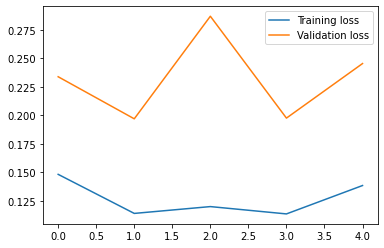

In [10]:
# Visualize the history
plt.plot(history.history['loss'], label = 'Training loss')
plt.plot(history.history['val_loss'], label = 'Validation loss')
plt.legend();

In [11]:
# Evaluate the history
LSTM_model.evaluate(X_test, y_test)

126/126 [==============================] - 1s 6ms/step - loss: 0.6940


0.6940297484397888

### Determine Anomalies

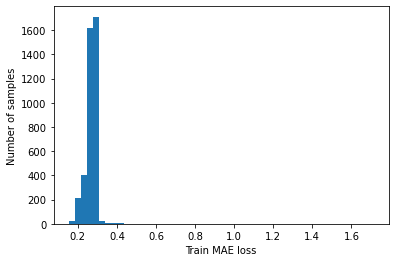

Reconstruction error threshold:  0.687950228652416


In [12]:
# Find MAE loss on the training data
X_train_pred = LSTM_model.predict(X_train, verbose = 0)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis = 1)

plt.hist(train_mae_loss, bins = 50)
plt.xlabel('Train MAE loss')
plt.ylabel('Number of samples');
plt.show()

# Get reconstruction of loss threshold
prediction_error = abs(X_train - X_train_pred)
threshold = np.mean(prediction_error) + 3 * np.std(prediction_error)
print('Reconstruction error threshold: ', threshold)

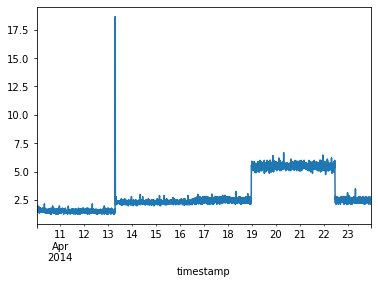

Test input shape:  (4022, 10, 1)


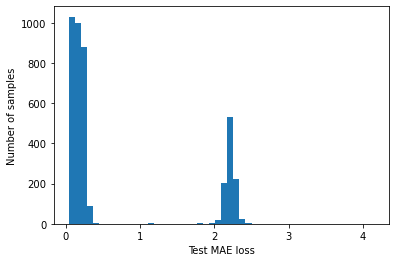

Number of anomaly samples:  1025


In [13]:
# Visualization of prediction

fig, ax = plt.subplots()
std_val.plot(legend = False, ax = ax)
plt.show()

# Create sequence from test values
print('Test input shape: ', X_test.shape)

# Get test MAE loss
X_test_pred = LSTM_model.predict(X_test, verbose = 0)
test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis = 1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins = 50)
plt.xlabel('Test MAE loss')
plt.ylabel('Number of samples')
plt.show()

# Detect all the samples which are anomalies
anomalies = test_mae_loss > threshold
print('Number of anomaly samples: ', np.sum(anomalies))

Text(0, 0.5, 'Index')

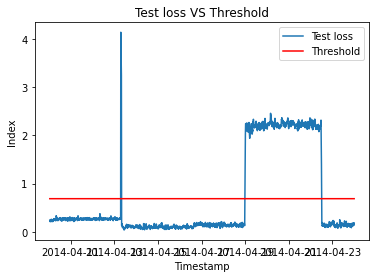

In [14]:
# Test loss versus threshold - visualisation
test_val_df = pd.DataFrame(std_val[TIME_STEPS:])
test_val_df['loss'] = test_mae_loss
test_val_df['threshold'] = threshold
test_val_df['anomaly'] = test_val_df['loss'] > test_val_df['threshold']
test_val_df['value'] = std_val[TIME_STEPS:]['value']

test_val_df.tail()

# Remaining variables to apply plt.scatter()
test_val_df_timestamp = np.array(test_val_df.index)
test_val_df_loss = test_val_df['loss']
test_val_df_threshold = test_val_df['threshold']

plt.figure()
plt.plot(test_val_df_timestamp, test_val_df_loss, label = 'Test loss')
plt.plot(test_val_df_timestamp, test_val_df_threshold, c = 'r', label = 'Threshold')
plt.legend()
plt.title('Test loss VS Threshold')
plt.xlabel('Timestamp')
plt.ylabel('Index')

In [15]:
# Plot anomalies

# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalous_data_indices = []

for data_idx in range(TIME_STEPS - 1, len(std_val) - TIME_STEPS + 1):
    if np.all(anomalies[data_idx - TIME_STEPS + 1: data_idx]):
        anomalous_data_indices.append(data_idx)

In [18]:
# Anomalies 
anomalies = test_val_df.loc[test_val_df['anomaly'] == True]
print(anomalies.shape)

anomalies.head()

anomalies_idxs = []
for i in range(len(anomalies)):
    for j in range(len(std_val)):
        if anomalies.index[i] == std_val.index[j]:
            anomalies_idxs.append(j)

(1025, 4)


In [20]:
layout = go.Layout(
    yaxis = dict(title = 'System Temperature'),
    xaxis = dict(title = 'Timestamp'), paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)', font_family="Times New Roman"
)

trace1 = go.Scatter(
    x = test_val_df.index,
    y = test_val_df.value,
    mode = 'lines',
    name = 'Non-anomaly',
    line = dict(shape = 'spline')
)

trace2 = go.Scatter(
    x = test_anomalies.index,
    y = test_anomalies.value, 
    mode = 'markers', name = 'Real Anomaly',
    marker = dict(color = 'green', size = 13)
)

trace3 = go.Scatter(
    x = anomalies.index,
    y = anomalies.value, 
    mode = 'markers', name = 'Predicted Anomaly',
    marker = dict(color = 'red', size = 10)
)

fig = go.Figure(data = [trace1, trace2, trace3], layout = layout)
py.offline.iplot(fig)